# Assignment 3:  Decision Tree Implementation
*Margaret Thomann - February 17, 2018 *

In this assignment, I will construct a decision tree from the data provided about heart disease.

### Reading the data and assigning counts to arrays and Data class

#### Data Class 
A Data class will be instantiated for each line of the data.  It will then be added to one of two arrays (explained later).

In [435]:
from collections import OrderedDict

class Data:
    def __init__(self, class_value):
        self.class_value = class_value
        self.data_vars = OrderedDict()

### Calculate Information Gain for Each Feature
The below function can be used to determine the information gain for a given data and hypothesis (passed in as a string - x and y).  Information Gain can be represented as: Infgain(Y|X_K) = H(Y) - H(Y|X_K)

In [436]:
# Arrays for the Data instances
#     absence_heart_array  : contains all Data instantiations where heart disease is absent
#     presence_heart_array : contains all Data instantiations where heart disease is absent
absence_heart_array = []
presence_heart_array = []
total_data_array = []

# Classify the features according to their type: nominal or continuous
indices_for_nominal = [10, 1, 5, 8, 6, 2, 12]
indices_for_continuous = [0,3,4,7,9,11]
feature_names = ["age", "sex", "chest_pain_type", "resting_blood_pressure", "serum_cholesterol", "fasting_blood_sugar",
                "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina",
                "oldpeak", "slope_peak_exercise", "number_of_major_vessels", "thal", "has_heart_disease"]
features_and_types = OrderedDict()
for feature in feature_names:
    if feature_names.index(feature) in indices_for_continuous:
        features_and_types[feature] = "continuous"
    else:
        features_and_types[feature] = "nominal"

# Process the data and store it in the arrays
data = open('heart.data.txt')
for line in data.readlines():
    feature_value_list = line.split()
    has_heart_disease = int(feature_value_list[-1])
    data = Data(has_heart_disease)
    counter = 0
    feature_dict = OrderedDict()
    for feature in feature_value_list:
        data.data_vars[feature_names[counter]] = float(feature)
        counter += 1
    if has_heart_disease == 2:
        presence_heart_array.append(data)
    elif has_heart_disease == 1:
        absence_heart_array.append(data)
    total_data_array.append(data)

presence_heart_array_num = len(presence_heart_array)
absence_heart_array_num = len(absence_heart_array)
print "✔ Data processed"
print "-----------------"
print "\t" + str(presence_heart_array_num) + " = # Of People with Heart Disease"
print "\t" + str(absence_heart_array_num) + " = # Of People without Heart Disease"

✔ Data processed
-----------------
	120 = # Of People with Heart Disease
	150 = # Of People without Heart Disease


### Utility Printer Function to Print out Data
The below function can be called with a Data object as its input to print out that data objects contents.

In [437]:
def print_data(data_obj):
    print "_____________"
    for feature in data_obj.data_vars.keys():
        print data_obj.data_vars[feature], ": ", feature

In [438]:
import math

def compute_info_gain(y, y_values, x, buckets, considered_data):
    
    #print "Calling compute_info_gain with y = "+y+" and x = "+x
    
        
    # Define dicts for the counts
    positive_y_counts = {}
    positive_x_counts = {}
    negative_y_counts = {}
    negative_x_counts = {}
    
    # Get the bucket values
    for bucket in buckets:
        # Convert to string
        s = ""
        for num in list(set(bucket)):
            s += (str(num)+ " ")
        positive_x_counts[s] = 0
        negative_x_counts[s] = 0
    
    
    for val in y_values:
        positive_y_counts[str(float(val))] = 0
        negative_y_counts[str(float(val))] = 0
    
    y_denom = 0
    for data in considered_data:
        y_denom += 1
        has_heart_disease = data.data_vars["has_heart_disease"]
        y_value = data.data_vars[y]
        x_value = data.data_vars[x]
        array_x = []
        array_y = []
        if has_heart_disease == 1:
            # Update all of the negative arrays
            array_x = negative_x_counts
            array_y = negative_y_counts
        elif has_heart_disease == 2:
            # Update all of the positive arrays
            array_x = positive_x_counts
            array_y = positive_y_counts
            
        # Value is not in dictionary yet
        # so set the occurrence for that value to 1
        for key in array_x.keys():
            if str(x_value)+" " in key:
                current_count_for_value = array_x[key]
                array_x.update({key:current_count_for_value+1})
                
        for key in array_y.keys():
            if str(y_value) in key:
                current_count_for_value = array_y[key]
                array_y.update({key:current_count_for_value+1})
            
    h_of_y = 0
    for count in positive_y_counts.values():
        entropy = 0
        if count != 0:
            p = float(float(count)/float(y_denom))
            entropy = -1 * p * (math.log(p, 2))
        h_of_y += entropy
    for count in negative_y_counts.values():
        entropy = 0
        if count != 0:
            p = float(float(count)/float(y_denom))
            entropy = -1 * p * (math.log(p, 2))
        h_of_y += entropy
    
    h_of_y_given_x = 0
    for feature_value in positive_x_counts.keys():
        entropy_positive = 0
        entropy_negative = 0
        sum_of_values = positive_x_counts[feature_value] + negative_x_counts[feature_value] 
        fraction = float(float(sum_of_values)/float(y_denom))
        if positive_x_counts[feature_value] != 0:
            p_positive = float(float(positive_x_counts[feature_value])/float(sum_of_values)) 
            entropy_positive = p_positive * (math.log(p_positive, 2))
        if negative_x_counts[feature_value] != 0:
            p_negative = float(float(negative_x_counts[feature_value])/float(sum_of_values)) 
            entropy_negative = p_negative * (math.log(p_negative, 2))
        
        h_of_y_given_x += fraction*(entropy_positive+entropy_negative)
    info_gain = h_of_y + h_of_y_given_x
    return info_gain


### Utility Function used to generate all of the possible splits
Credit:  https://stackoverflow.com/questions/19368375/set-partitions-in-python/30134039#30134039

In [439]:
def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller

### Determine possible splits
These will be used for the information gain

In [440]:
# get_continuous_binary_split(feature):     
#    Gets a feature and splits the data for that feature in all the possible ways to split that
#    data into two buckets.  It returns a dictionary where the key is the number it split on and the
#    value is a list of two lists.  The first element of the list is all of the elements less than
#    the split and the second element of the list is a list of all of the elements greater than or
#    equal to the split.
#    For example:
#           feature = "age"
#           splits_dict = {50: [[20,40,43...],[50,60,61...]], 60: [[57,45,59...],[60,61,63...]]}
def get_continuous_binary_split(feature, considered_data):
    # Ensure the function is being called only with continuous features
    if features_and_types[feature] != "continuous":
        raise ValueError('Error in get_continuous_binary_split: input feature is not continuous.')
        return
    
    # Create a list of the possible splits
    splits = []
    counts_for_feature_values = {}
    
    #print "The Length of the Considered Data: ",len(considered_data)
    
    for data in considered_data:
        feature_value = float(data.data_vars[feature])
        if feature_value not in splits:
            splits.append(feature_value)
        if feature_value not in counts_for_feature_values:
            counts_for_feature_values[feature_value] = 1
        else:
            current = counts_for_feature_values[feature_value]
            counts_for_feature_values[feature_value] = current + 1
    
    # Process the splits and create the less than list and greater than or equal to list for each
    splits_list = []
    for split in splits:
        lt_split_feature_values = []
        gtequal_split_feature_values = []
        for data in considered_data:
            feature_value = float(data.data_vars[feature])
            if feature_value < split:
                lt_split_feature_values.append(feature_value)
            else:
                gtequal_split_feature_values.append(feature_value)
        #if len(lt_split_feature_values) != 0:
        splits_list.append([lt_split_feature_values, gtequal_split_feature_values])
            
    # Generate a list of partition dicts
    # Each list element will be a list of dictionaries
    # The dictionaries will contain the feature_value and the number of times it occurs
    # The list of these dictionaries will be split up by partition
    partitions_and_values = []
    for partition in splits_list:
        split_inclusive = []
        for l in partition:
            set_l = set(l)
            count_dict = {}
            for feature_value in set_l:
                num_of_feature_value_occurrences = counts_for_feature_values[feature_value]
                count_dict[feature_value] = num_of_feature_value_occurrences
            split_inclusive.append(count_dict)
        partitions_and_values.append(split_inclusive)
            
    return partitions_and_values

In [441]:
import itertools
# get_nominal_split(feature):     
#    Gets a nominal feature and splits the data for that feature in all the possible ways to split that
#    data into every possible number of buckets.  It returns a dictionary where the key is the number it 
#    split on and the value is a list of the lists it generated from the split.  

def split_list(data, n):
    from itertools import combinations, chain
    for splits in combinations(range(1, len(data)), n-1):
        result = []
        prev = None
        for split in chain(splits, [None]):
            result.append(data[prev:split])
            prev = split
        yield result
        
def get_nominal_split(feature, considered_data):
    # Ensure the function is being called only with nominal features
    if features_and_types[feature] != "nominal":
        raise ValueError('Error in get_nominal_split: input feature is not nominal.')
        return
    
    #print "get_nominal_split called with feature: "+feature
    # Determine the unique values for the feature and the counts for the feature_value
    splits = {}
    split_nums = []
    for data in considered_data:
        feature_value = float(data.data_vars[feature])
        if feature_value not in splits:
            split_nums.append(feature_value)
            splits[feature_value] = 1
        else:
            current_num = splits[feature_value]
            splits[feature_value] = current_num+1
    
    #print "possible values for feature:"
    #print split_nums

    # Generate all the possible ways to partition the numbers  
    # possible_partitions is a list of tuples where the first element of the tuple
    # is the kth possible partition and the second element of the tuple is a list
    # of lists of partitions
    possible_partitions = []
    for p in partition(split_nums):
        # Be sure to remove the split where all values are placed in one bucket
        if (len(sorted(p)) != 1) or ((len(sorted(p)) == 1) and (len(split_nums) == 1)):
            possible_partitions.append(sorted(p))
    #print "possible_partitions:"
    #print possible_partitions
                
    # Generate a list of partition dicts
    # Each list element will be a list of dictionaries
    # The dictionaries will contain the feature_value and the number of times it occurs
    # The list of these dictionaries will be split up by partition
    partitions_and_values = []
    for split_lists in possible_partitions:
        split_dicts = []
        for bucket in split_lists:
            bucket_dict = {}
            for feature_value in bucket:
                num_of_feature_value_occurrences = splits[feature_value]
                bucket_dict[feature_value] = num_of_feature_value_occurrences
            split_dicts.append(bucket_dict)
        partitions_and_values.append(split_dicts)
    return partitions_and_values

### Compute the best split
Checks the information gain for all the possible splits for a certain feature and reports the best one.

In [442]:
def compute_best_split(y, y_values, feature, considered_data):
    # Check if the feature is nominal or continuous and split accordingly
    splits = []
    if features_and_types[feature] == "nominal":
        
        splits = get_nominal_split(feature, considered_data)
    else:
        splits = get_continuous_binary_split(feature, considered_data)
    
    # Create a dictionary where the key is the information gain from a particular
    # split and the value is that particular split
    info_gains = {}
    for split in splits:
        info_gain = compute_info_gain(y, y_values, feature, split, considered_data)
        info_gains[info_gain] = split
    max_info_gain = max(info_gains, key=float)
    split_yielding_max_info_gain = info_gains[max_info_gain]
    return max_info_gain, split_yielding_max_info_gain

### Tree Class
Set up classes for the tree.

In [443]:
class Node(object):
    def __init__(self, splitting_feature, feature_value, feature_value_occurrence, data):
        self.splitting_feature = splitting_feature
        self.feature_value = feature_value
        self.feature_value_occurrence = feature_value_occurrence
        self.data = data
        self.id = ""
        self.children = []
        self.parent = None

    def add_child(self, obj):
        self.children.append(obj)
    def print_node(self, node):
        print "\t id: ", node.id
        print "\t splitting_feature: ", node.splitting_feature
        print "\t feature_value: ", node.feature_value
        print "\t feature_value_occurrence: ", node.feature_value_occurrence
        print "\t # children: ", len(node.children)
    
    def print_children(self):
        counter = 1
        for child in self.children:
            print counter, ":"
            self.print_node(child)
            counter += 1
    
    def print_node_and_children(self):
        print "*   NODE  *"
        self.print_node(self)
        print "* CHILDREN *"
        self.print_children()
    
    def assign_edges(self, ids):
        # Process the children
        children_with_ids_array = []
        
        for child in self.children:
            assigned_child_id = False
            for id_key in ids:
                node = ids[id_key]
                if child.is_equal(node):
                    child.id = id_key
                    assigned_child_id = True
                    children_with_ids_array.append(child)
                    break
            if assigned_child_id == False:
                unique_id = str(uuid.uuid4())
                child.id = unique_id
                children_with_ids_array.append(child)
                ids[unique_id] = child
        
        del self.children[:]
        
        self.children = children_with_ids_array
                    
                    
        assigned_id = False
        for id_key in ids:
            node = ids[id_key]
            if self.is_equal(node):
                self.id = id_key
                node.children = self.children
                assigned_id = True
                break
                
        if assigned_id == False:
            unique_id = str(uuid.uuid4())
            self.id = unique_id
            ids[unique_id] = self
        return ids
            
        
    def is_equal(self, leaf):
        if self.parent and leaf.parent:
            if not self.parent.is_equal(leaf.parent):
                return False
        
        if (self.splitting_feature == leaf.splitting_feature) and (self.feature_value == leaf.feature_value) and (self.feature_value_occurrence == leaf.feature_value_occurrence):
            return True
        else:
            return False
            

### Split Data
Split the data and return a list of arrays of the split data given the feature and the splits

In [444]:
def split_data(feature, splits, considered_data):
    #print "Splitting data for feature: "+feature
    #print "split is: "
    #print splits
    data = []
    for split in splits:
        data.append([])
    separate_buckets = {}
    for data in considered_data:
        feature_value = float(data.data_vars[feature])
        if feature_value not in separate_buckets.keys():
            new_list = []
            new_list.append(data)
            separate_buckets[feature_value] = new_list
        else:
            current_list = separate_buckets[feature_value]
            current_list.append(data)
            separate_buckets[feature_value] = current_list
            
    new_data = []
    for split in splits:
        
        
        # Convert it to a list
        split_list = []
        if len(split) == 1:
            
            split_list.append(split)
        else:
            split_list.append(split)
        
        # Prepare a list for the data of that split
        data_for_split = []
        
        # Get all the valid feature_values for that particular split
        valid_feature_values = []
        #print "SPLIT LIST IN SPLIT DATA: ", split_list
        for split_dict in split_list:
            for feature_value_key in split_dict.keys():
                valid_feature_values.append(feature_value_key)
        
        # Process the valid feature values, find matching data, and add it to the data for that split
        for feature_value in valid_feature_values:
            for data_pt in separate_buckets[feature_value]:
                data_for_split.append(data_pt)
        
        # Add the data relevant for a certain split group to the new data array
        new_data.append(data_for_split)
    
    return new_data

### Recurse to build the tree
Used the information gain function to determine the best splits for each node of the tree.

In [445]:
def build_tree(y, y_values, data, allowable_features_to_split_on):
    info_gains = {}
    split_yielding_max_info_gain = []
    for feature in allowable_features_to_split_on:
        if feature != y:
            info_gain, split_yielding_max_info_gain = compute_best_split(y, y_values, feature, data)
            info_gains[feature] = [info_gain, split_yielding_max_info_gain]

    #print info_gains

    # Printing out the information gains for each feature
    
    '''
    for feature in info_gains.keys():
        print str(info_gains[feature][0])+" : "+feature
    '''
    

    # Find the maximum in the info_gains returned
    max_info_gain = 0
    best_split = []
    best_feature = ""
    
    # Check if they are all equal to 0
    counter = 0
    total = 0
    for feature in info_gains.keys():
        if info_gains[feature][0] == 0:
            counter += 1
        total += 1
    if counter == total:
        return
    
    #print info_gains.keys()
    for feature in info_gains.keys():
        if info_gains[feature][0] > max_info_gain:
            max_info_gain = info_gains[feature][0]
            best_split = info_gains[feature][1]
            best_feature = feature
            
    # Check if they all equal zero
    all_zeroes = True
    for feature in info_gains.keys():
        if info_gains[feature][0] != 0:
            all_zeroes = False
            
    if all_zeroes:
        # Return what it was called on
        return y, data, y_values
    
    #print max_info_gain
    #print best_feature
    # Split on that feature and optimal split
    new_data = split_data(best_feature, best_split, data)

    # Define the new y based on this data
    y = feature
    
    #print best_split
    return best_feature, new_data, best_split

In [446]:
import uuid
y = "has_heart_disease"
allowable_features_to_split_on = data.data_vars.keys()

feature, new_data, best_split = build_tree(y, [2, 1], total_data_array, allowable_features_to_split_on)
levels = []
levels.append([feature, new_data, best_split])
#print best_split
#print "Length of new data ", len(new_data)
possible_y_vals_array = []
for split in best_split:
    new_list = []
    for y_val in split.keys():
        new_list.append(y_val)
    possible_y_vals_array.append(new_list)
    
# Edit the features allowed to split on
allowable_features_to_split_on.remove("has_heart_disease")
tree_array = []
# Process each feature 
# level = [0: feature, 1: new_data, 2: best_split]
new_levels = []
tree_is_finished = False
processed_els = 0
ids = OrderedDict()
unique_id = str(uuid.uuid4())
node = Node(feature, best_split[0].keys(), sum(best_split[0].values()), new_data)
node.id = unique_id
ids[unique_id] = node
processed = 0
while not tree_is_finished:    
    for level in levels:
        # Process each split for the feature
        for branch_index in range(len(level[1])):
            current_leaf = Node(level[0], level[2][branch_index].keys(), sum(level[2][branch_index].values()),level[1][branch_index])
            tree_array.append(current_leaf)
            data_for_next_call = level[1][branch_index]
            # Edit the allowable features to split on since if you split on a nominal feature and only have 
            # one value for that nominal feature in the branch, you shouldn't split on it again
            if features_and_types[feature] == "nominal" and len(possible_y_vals_array[0]) == 1 and level[0] in allowable_features_to_split_on:
                allowable_features_to_split_on.remove(level[0])
            if len(allowable_features_to_split_on) != 0:
                #print "Length of the data for the next call: ", len(data_for_next_call)
                if len(data_for_next_call) > 0:

                    possible_y_values = []
                    for pt in data_for_next_call:
                            y_value = pt.data_vars[level[0]]
                            if y_value not in possible_y_values:
                                possible_y_values.append(y_value)

                    try:
                        next_feature, next_new_data, next_best_split = build_tree(level[0], possible_y_values, data_for_next_call, allowable_features_to_split_on)

                        # Add the children for the current leaf
                        for child_index in range(len(next_new_data)):
                            child_splitting_feature = next_feature
                            child_feature_value = next_best_split[child_index].keys()
                            child_feature_value_occurrence = sum(next_best_split[child_index].values())
                            child = Node(child_splitting_feature, child_feature_value, child_feature_value_occurrence,next_new_data)
                            child.parent = current_leaf
                            current_leaf.add_child(child)

                        #print " Number of children for leaf: ", len(current_leaf.children)
                        new_levels.append([next_feature, next_new_data, next_best_split])

                        ids = current_leaf.assign_edges(ids)

                        # Put feature back in allowable features because it's possible we might need it later
                        allowable_features_to_split_on.append(level[0])

                    except TypeError:
                        #pass

                        # Put feature back in allowable features because it's possible we might need it later
                        allowable_features_to_split_on.append(level[0])

                        #print "Reached a conclusion for ", len(data_for_next_call)
                        #print "pure leaf: ", level[0]
                        processed_els += len(data_for_next_call)
                        #print "Processed = ", processed_els
                        if processed_els >= 270:
                            tree_is_finished = True
                        continue
                    
    # Levels has finished processing
    del levels[:]
    
    # Set the levels equal to everything in the new_levels
    for s in new_levels:
        levels.append(s)
        
    # Also delete the ones you've processed in new_levels
    del levels[0:processed*3]
    
    processed += 1
    
    
    
        

[{3.0: 152}, {6.0: 14}, {7.0: 104}]


### Tree Visualization
Use the tree_array and the graphviz algorithm to build a tree visualization.

TOTAL DATA POINTS PROCESSED ON TREE:  270


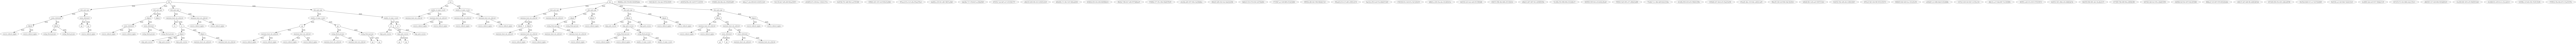

In [465]:
# Imports for the visualization
import uuid
from graphviz import Digraph
from graphviz import Source
from graphviz import render
from IPython.display import Image


# Initialize the graph
dot = Digraph(comment='Heart Data Decision Tree')

# Go through the tree nodes with unique ids and add them as nodes to the graph
for leaf in ids.keys():
    if features_and_types[ids[leaf].splitting_feature] == "continuous":
        dot.node(str(leaf), ids[leaf].splitting_feature)
        '''
        max_val = ""
        min_val = ""
        if len(ids[leaf].feature_value) > 0:
            max_val = max(ids[leaf].feature_value)
        if len(ids[leaf].feature_value) > 0:
            min_val = min(ids[leaf].feature_value)
        dot.node(str(leaf), (str(min_val) + " <= " + ids[leaf].splitting_feature + " <= " + str(max_val)) + "\n" + "# = "+str(ids[leaf].feature_value_occurrence))
        '''
    else:
        dot.node(str(leaf), ids[leaf].splitting_feature)
        #dot.node(str(leaf), ids[leaf].splitting_feature + " = " + ', '.join(str(e) for e in ids[leaf].feature_value)+ "\n" + "# = "+str(ids[leaf].feature_value_occurrence))

for leaf_a in ids.keys():
    leaf_node = ids[leaf_a]

# Go through the children for each and assign edges
#print "length of id keys ", len(ids.keys())
total_leaves = 0
for leaf_id in ids.keys():
    leaf_node = ids[leaf_id]
    #print "Checking ", leaf_node.splitting_feature, " with value ", leaf_node.feature_value, " and children = ", len(leaf_node.children)
    for child in leaf_node.children:
        #print "Putting an edge between ", leaf_node.splitting_feature, " and ", child.splitting_feature
        #print "Splits are: ", leaf_node.feature_value, " and ", child.feature_value
        label_text = ""
        if features_and_types[child.splitting_feature] == "continuous": 
            max_val = ""
            min_val = ""
            if len(child.feature_value) > 0:
                max_val = max(child.feature_value)
            if len(child.feature_value) > 0:
                min_val = min(child.feature_value)
            label_text = str(min_val) + " <= " + child.splitting_feature + " <= " + str(max_val)) + "\n" + "# = "+str(child.feature_value_occurrence)
        
        else:
            
        
        dot.edge(leaf_id, child.id, label=label_text, constraint="true")
    if (len(leaf_node.children) == 0):
        total_leaves += leaf_node.feature_value_occurrence
        #print leaf_node.splitting_feature, " is an edge with value ", leaf_node.feature_value, " occurrence = ", leaf_node.feature_value_occurrence
        # Add a node that has the instances
        unique_id = str(uuid.uuid4())
        absence_count = 0
        presence_count = 0
        for data_pt in leaf_node.data[0]:
            has_heart_disease = data_pt.data_vars["has_heart_disease"]
            if has_heart_disease == 1:
                absence_count += 1
            elif has_heart_disease == 2:
                presence_count += 1
        dot.node(unique_id, )

print "TOTAL DATA POINTS PROCESSED ON TREE: ", total_leaves
dot.render('heart-decision-tree.gv', view=True)
render('dot', 'png', 'heart-decision-tree.gv') 
Image('heart-decision-tree.gv.png')
#Source.from_file('heart-decision-tree.gv')



    
